In [ ]:
import pandas as pd
import os

In [ ]:
pwd = os.getcwd()
filepath = os.path.join(pwd, "wine.csv")

In [ ]:
data_import = pd.read_csv(filepath)
data_import

In [ ]:
#quality is a column in this dataset. This is what we are looking to predict

data_import["quality"].hist()

In [ ]:
# based on the above histogram, we are going to classify wine as good if quality is greater than 5 and bad if less than 5

y= data_import["quality"] > 5
y

In [ ]:
X = data_import.drop("quality", axis = 1)
X

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled


In [ ]:
def preprocessing_function(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test


In [ ]:
from sklearn.svm import SVC #support vector classifier


svc_clf = SVC()
svc_clf.fit(X_train_scaled, y_train)


In [ ]:
svc_clf_predictions = svc_clf.predict(X_test_scaled)
svc_clf_predictions

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def algo_accuracy(y_test, predictions):
    cm = confusion_matrix(y_test, svc_clf_predictions, labels= svc_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_clf.classes_)
    disp.plot()
    plt.show()

    accuracy=accuracy_score(y_test, svc_clf_predictions)
    precision = precision_score(y_test, svc_clf_predictions)
    recall = recall_score(y_test, svc_clf_predictions)
    return accuracy, precision, recall


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    #try 12 (3x4) combinations of hyperparameters
    {
        'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    #then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},

]

rfc = RandomForestClassifier()

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
rfc_clf = grid_search.best_estimator_
rfc_clf

In [ ]:
rfc_predictions = rfc_clf.predict(X_test)
rfc_predictions

In [ ]:
algo_accuracy(y_test, rfc_predictions)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]


knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

In [ ]:
knn_clf = grid_search.best_estimator_

print(knn_clf)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

In [ ]:
sample = mnist.target[:10]
sample

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

In [ ]:
train_data.value_counts()

In [ ]:
train_data.head()

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")


In [ ]:
train_data.info()

In [ ]:
#calculate the median age of female passengers
train_data[train_data["Sex"] == "female"]["Age"].median()

In [ ]:
train_data.describe()

In [ ]:
#check if survived columns has 0 or 1 as values
train_data["Survived"].value_counts()

In [ ]:
# look at all the categorical columns
train_data["Sex"].value_counts()

In [ ]:
#list all categorical columns in train_data
#train_data.dtypes[train_data.dtypes == "object"].index
# this left out a few columns so we need to improve the condition to see all categorical columns
train_data.dtypes[train_data.dtypes != "int64"].index

In [ ]:
# get info on Pclass column
train_data["Pclass"].value_counts()

In [24]:
# lets build preprocessing pipeline, starting with the neumerical attributes
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [25]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False)),
])

In [26]:
#let's join the two pipelines
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [27]:
#lets apply the pipeline to the training data
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [28]:
y_train = train_data["Survived"]
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [29]:
#now lets train a classifier start with RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100,   random_state=42)
forest_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [30]:
#now lets predict on the test set

X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [31]:
from sklearn.model_selection import cross_val_score

forest_score = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_score.mean()

0.8160049937578027

In [32]:
#lets try SVC

from sklearn.svm import SVC

svc_clf = SVC(gamma="auto")
svc_clf.fit(X_train, y_train)

svc_score = cross_val_score(svc_clf, X_train, y_train, cv=10)  
svc_score.mean()

0.8249313358302123

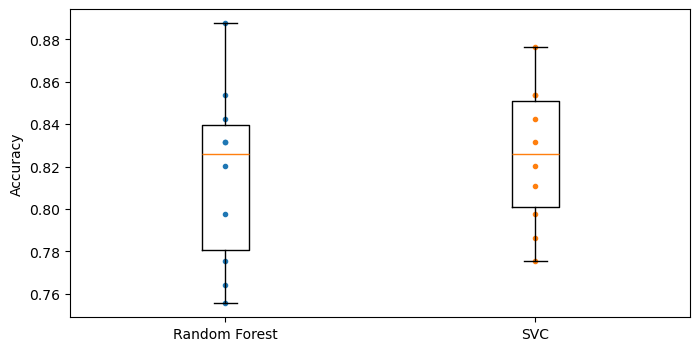

In [34]:
#lets plot all 10 scores for each model

from matplotlib import pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot([1]*10, forest_score, ".")
plt.plot([2]*10, svc_score, ".")
plt.boxplot([forest_score, svc_score], labels=("Random Forest", "SVC"))
plt.ylabel("Accuracy")
plt.show()


In [35]:
# let's create an age buckets based on "Age" column

train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()


,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [36]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [37]:
# now let's retrain the model

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [38]:
#let's do some predictions

X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

# get the score

forest_score = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_score.mean()

0.8160049937578027